# Position embeddings
The goal of this small tutorial is to help you understand position embeddings.

Recall that the formulas to compute the position embeddings are:

> $P[k,2i] = \sin (\frac{k}{n^{2i/d}})$

> $P[k,2i+1] = \cos (\frac{k}{n^{2i/d}})$

where
- $P[k,:]$ is the position embedding of the $k$'th input token
- $d$ is the dimension of the position embedding space (same as word embedding dimension)
- $n$ is a user-defined scalar, set to 10,000 by the authors of the Transformer paper.
- $𝑖$ is used for indexing the columns of the position embedding, $0 \le i \le d/2-1$

You can see that even positions correspond to a sine function and odd positions correspond to cosine functions.

Let's define a function to compute the position embeddings, given $d$, $n$, and the sequence length.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def get_position_encoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))

    # Loop over all input positions
    for k in range(seq_len):

        # Loop over embedding dimension
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)

    return P

## Displaying the position embeddings as an image
We can display $P$ is an image for same choice of $d$, $n$, and sequence length. Let's pick $d=32$, $n=100$, and sequence length = 16.

Shape of P: (16, 32)


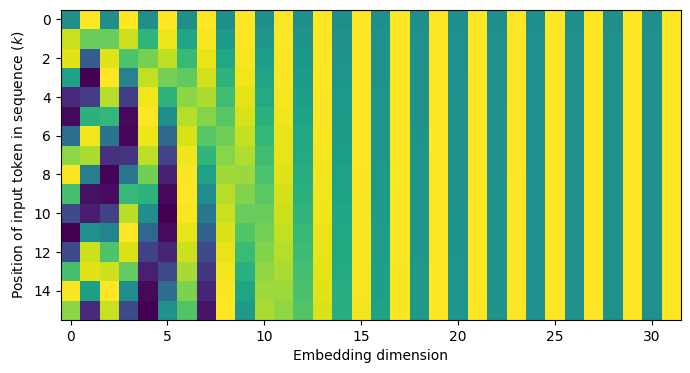

In [3]:
P = get_position_encoding(seq_len=16, d=32, n=10000)

print("Shape of P:", P.shape)
plt.figure(figsize=(8,8))
_ = plt.imshow(P)
_ = plt.xlabel('Embedding dimension')
_ = plt.ylabel('Position of input token in sequence ($k$)')

## Intuition
What is the intuition behind the definition of $P$?

To understand this, let's first realize that for every $i$ ($0 \le i \le d/2-1$), the pair $(P[k,2i], P[k,2i+1])$ forms a vector on the unit circle. As we increase $k$, this vector starts rotating (why?).

Let's plot this vector for different combinations of $k$ and $i$. For each $i$ (row), you should see that the vector rotates as we increase $k$.

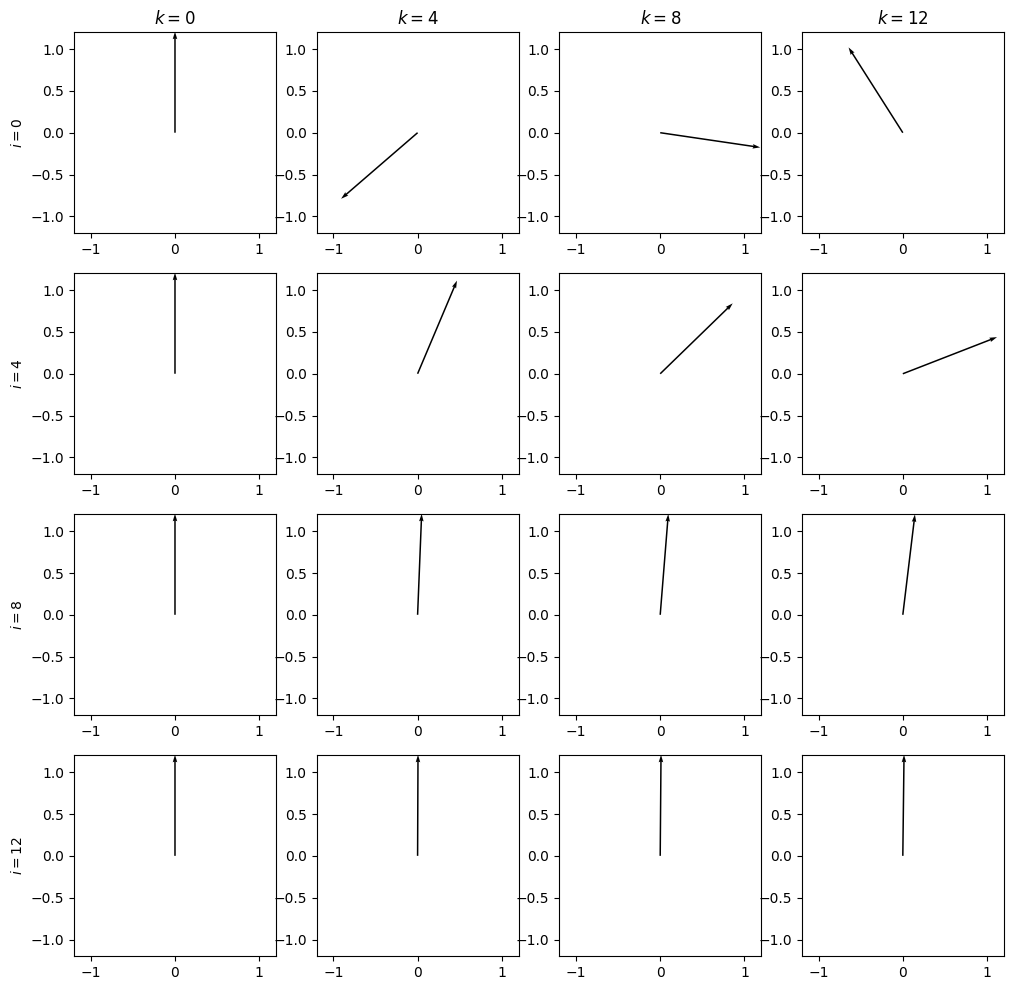

In [4]:
seq_len = 16
d = 32
plt.figure(figsize=(12,12))
for row, i in enumerate(range(0, d//2, 4)):
  for col,k in enumerate(range(0,seq_len,4)):
    plt.subplot(4,4,row*4 + col+1)
    plt.quiver([0],[0], P[k,2*i], P[k,2*i+1], scale=2)
    plt.axis([-1.2, 1.2, -1.2, 1.2])
    if row == 0:
      plt.title(f"$k={k}$")
    if col == 0:
      plt.ylabel(f"$i={i}$")

## Question
- What is the role of $n$? (hint: one way to find out would be to change it and make the above plots again).

## Pairwise distance between position embeddings
By *construction*, tokens that are close to each other in the sequence will have similar position embeddings, and tokens that are far apart will have dissimilar embeddings. This way the Transformer has a way of inferring if two tokens are close to each other or far apart in the input sequence.

Let's verify this by computing the pairwise distance between all position embeddings:

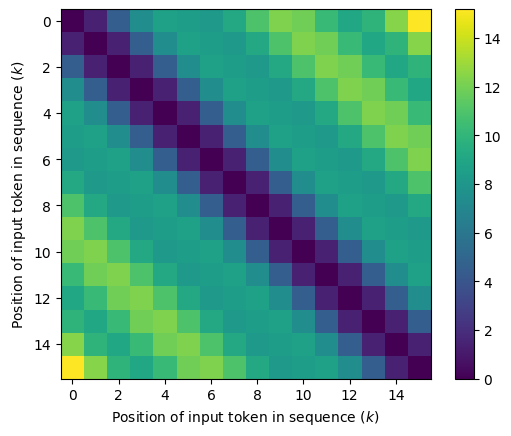

In [5]:
from sklearn.metrics.pairwise import pairwise_distances
distances = pairwise_distances(P, P, metric='sqeuclidean')
_ = plt.imshow(distances)
plt.xlabel('Position of input token in sequence ($k$)')
plt.ylabel('Position of input token in sequence ($k$)')
plt.colorbar()

## Question
- What is the distance between token $k=0$ and token $k=1$ (roughly)?
- What is the distance between token $k=0$ and token $k=15$ (roughly)?
- In general, what is the distance between token $k=i$ and token $k=i+j$ for any choice of $i,j \ge 0$ (roughly)?

## Transformer example
The code below implements a simplified Transformer for sequence classification. The point is to show how position embeddings are included in practise.

In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# Sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, embed_dim, n=10000):
        super().__init__()
        self.d = embed_dim # embedding dimension
        self.n = n

    def forward(self, k):
        # k is the token index
        half_dim = self.d // 2
        denominator = torch.pow(self.n, 2*torch.arange(half_dim)/self.d)
        emb = k[:, None] / denominator[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# "Encoder-Only" Style Transformer
class NanoTransformer(nn.Module):
    """
    This class implements a simplified Transformer for sequence classification.
    It uses an embedding layer for tokens, sinusoidal positional embeddings,
    a single Transformer encoder, and a final linear layer for prediction.

    Args:
      vocab_size: The number of unique tokens in the vocabulary.
      output_size: The size of the output layer (number of classes).
      embed_dim: The embedding dimension used in the Transformer block (default: 128).
      num_heads: The number of heads in the multi-head attention layer (default: 4).
    """
    def __init__(self, vocab_size, output_size, embed_dim=128, num_heads=4):
        super(NanoTransformer, self).__init__()

        # Create learnable word embedding for each token
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Create position embeddings (what we called P above)
        self.pos_emb = SinusoidalPosEmb(embed_dim)

        # Self-attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads=num_heads, batch_first=True)

        # Simple classifier (MLP)
        self.fc_out = nn.Sequential(nn.Linear(embed_dim, embed_dim),
                                 nn.LayerNorm(embed_dim),
                                 nn.ELU(),
                                 nn.Linear(embed_dim, output_size))

    def forward(self, input_seq):
        bs, l = input_seq.shape
        input_embs = self.embedding(input_seq)

        # Add a unique embedding to each token embedding depending on it's position in the sequence
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, -1).expand(bs, l, -1)
        embs = input_embs + pos_emb

        output, attn_map = self.multihead_attn(embs, embs, embs)

        return self.fc_out(output), attn_map

We will not train the model; just show how it works on arbitrary input data (hence, the embedding size, vocabulary size, and number of classes are somewhat arbitrary).

In [7]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Embedding size
embed_dim = 32

# Vocabulary size (number of unique words in our vocabulary)
vocab_size = 1000

# Number of classes
num_classes = 4

# Create the Transformer model
nano_transformer = NanoTransformer(vocab_size=vocab_size, output_size=num_classes,
                                embed_dim=embed_dim, num_heads=4).to(device)

In [10]:
# Generate a random batch
batch_size = 8
seq_length = 16

input = torch.randint(0, vocab_size, (batch_size,seq_length))
print("Input shape:", input.numpy().shape)

Input shape: (8, 16)


In [13]:
# Make prediction
predictions, attn_map = nano_transformer(input)
print("Shape of predictions:", predictions.detach().numpy().shape)
print("Shape of attn_map:", attn_map.detach().numpy().shape)

Shape of predictions: (8, 16, 4)
Shape of attn_map: (8, 16, 16)


## Question
- What do `predictions` and `attn_map` represent, and why do they have the shapes they have?